In [1]:
import os
import io
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import float32
from tensorflow.image import resize, rgb_to_grayscale, convert_image_dtype
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from config import IMG_HEIGHT, IMG_WIDTH
from src.modules import data_loader
from src.face_recognition import ml_models


################## PATH ##################
DB_PATH = r"..\data\gui_database.db"
LFW_DATASET_PATH = r"..\data\dataset-lfw_reconstructed"
ML_OUTPUT = r"..\data\ml_models"
MODEL_SAVE_DIR = f'{ML_OUTPUT}/trained'
LOG_DIR = f'{ML_OUTPUT}/logs'


############# MODEL SETTINGS #############
#####--- prepare_data_train_model ---#####
INPUT_SHAPE = (100, 100, 1)
IMG_WIDTH, IMG_HEIGHT, CHANNELS = INPUT_SHAPE
SPLIT_STRATEGY = 'stratified'
TEST_SPLIT_RATIO = 0.2
VALIDATION_SPLIT_RATIO = 0.15
RANDOM_STATE = 42
N_TRAIN_PER_SUBJECT = 7
#####--- create_model ---#####
MODEL_NAME = 'simple_cnn_lfw_anony_v1'
MODEL_ARCHITECTURE = 'simple_cnn'
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10
TRANSFER_BASE_MODEL_NAME = 'MobileNetV2'
TRANSFER_FREEZE_BASE = True
#####--- train_model ---#####
BATCH_SIZE = 32
EPOCHS = 50
##########################################

# Import Data

### Noised DB dataset

In [2]:
import controller.ml_controller as mlc

X, y, label_encoder = mlc.MLController.get_data_from_db(DB_PATH)
print(f"(nb_image, width, height, channels) : {X.shape}")

(nb_image, width, height, channels) : (467, 100, 100, 3)


### Noised LFW dataset

In [3]:
import controller.ml_controller as ml
os.makedirs(LFW_DATASET_PATH, exist_ok=True)

X, y, label_encoder = ml.data_loader.load_anonymized_images_flat(
    data_dir=LFW_DATASET_PATH,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    color_mode='grayscale'
)

if not X.shape and not y.shape and not label_encoder:
    raise ValueError('Critical error while loading data. Script stopped..')
print(f"\n(nb_image, width, height, channels) : {X.shape}")

Chargement des images depuis : ..\data\dataset-lfw_reconstructed
Format attendu : 100x100, mode: grayscale
Trouvé 1240 fichiers PNG.
Chargement terminé. 1240 images traitées, 0 fichiers ignorés.
Shape final des données (X): (1240, 100, 100, 1)
1240 labels originaux encodés en 62 classes numériques.

(nb_image, width, height, channels) : (1240, 100, 100, 1)


# Train

In [4]:
def formate_ml_image(
    image: np.array,
    img_width: int,
    img_height: int,
    keep_rgb_channels: bool=False
    ):
    # Convert to grayscale
    if image.ndim == 2:
        image = image[..., np.newaxis]
    elif image.shape[2] == 3:
        if not keep_rgb_channels:
            image = rgb_to_grayscale(image).numpy()
    elif image.shape[2] != 1:
        raise ValueError("Image must be grayscale or RGB.")
    # Resize & normalize image
    image = convert_image_dtype(image, dtype=float32)
    image = resize(image, [img_width, img_height], method="area").numpy()
    return image

def prepare_data_train_model(
    X, y, label_encoder,
    input_shape=(100, 100),
    split_strategy='stratified',
    test_split_ratio=0.2,
    validation_split_ratio=0.15,
    random_state=42,
    n_train_per_subject=7,
    show_logs=False
    ):
    """
    Prepare data for facial recognition model.

    --- Images & labels set & image size
    :param X: dataset (numpy array of images)
    :param y: labels
    :param label_encoder: sklearn.preprocessing._label.LabelEncoder
    :param input_shape:  (width, height) of images.
    --- Data Division Settings ---
    :param split_strategy: Division strategy: 'stratified' or 'fixed_per_subject'
    --- For 'stratified' split_strategy ---
    :param test_split_ratio: Proportion of the total dataset to use for the test set
    :param validation_split_ratio: Proportion of the total dataset to use for the validation set. Will be subtracted from the training set if non-zero.
    --- For 'fixed_per_subject' split_strategy ---
    :param random_state: Seed for reproducibility of divisions and initializations
    :param n_train_per_subject: Exact number of images per subject for the training set. (Ignored if SPLIT_STRATEGY is not 'fixed_per_subject')
    --- Display print logs ---
    :param show_logs:

    :return num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data
    """
    # --- ------------------- ---
    # --- 2. Data Preparation ---
    # --- ------------------- ---

    if X is None or y is None or label_encoder is None:
        raise Exception("No data")

    # Display model parameters
    if show_logs:
        print("Custom configuration loaded:")
        print(f"  - Image Dimensions: {input_shape}")
        print(f"  - Split Strategy: {split_strategy}")
        print("\n--- Prepare data ---")

    # Normalize images in the same shape
    X = np.array([formate_ml_image(img, input_shape[0], input_shape[1]) for img in X])

    # Get the total number of classes from the label encoder
    num_classes = len(label_encoder.classes_)
    if show_logs: print(f"Number of classes detected: {num_classes}")

    # --- ---------------- ---
    # --- 3. Data Division ---
    # --- ---------------- ---
    if SPLIT_STRATEGY == 'stratified':
        data_splits = data_loader.split_data_stratified(
            X, y,
            test_size=TEST_SPLIT_RATIO,
            validation_size=VALIDATION_SPLIT_RATIO,
            random_state=RANDOM_STATE
        )
        X_train = data_splits.get('X_train')
        y_train = data_splits.get('y_train')
        X_val = data_splits.get('X_val')
        y_val = data_splits.get('y_val')
        X_test = data_splits.get('X_test')
        y_test = data_splits.get('y_test')

        if X_val is None and VALIDATION_SPLIT_RATIO > 0 and X_train is not None and len(X_train) > 0:
             val_ratio_from_train = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO)
             if val_ratio_from_train < 1.0:
                 if show_logs: print(f"Creation of the validation set from training (ratio: {val_ratio_from_train:.2f})")
                 X_train, X_val, y_train, y_val = train_test_split(
                     X_train, y_train,
                     test_size=val_ratio_from_train,
                     random_state=RANDOM_STATE,
                     stratify=y_train
                 )
             else:
                 print("Warning: Inconsistent split ratios, no training data remaining after validation.")

    elif SPLIT_STRATEGY == 'fixed_per_subject':
        X_train_full, X_test, y_train_full, y_test = data_loader.split_data_fixed_per_subject(
            X, y,
            n_train_per_class=N_TRAIN_PER_SUBJECT,
            random_state=RANDOM_STATE
        )
        if VALIDATION_SPLIT_RATIO > 0 and X_train_full is not None and len(X_train_full) > 0:
            if show_logs: print(f"Creation of the validation set from training (ratio: {VALIDATION_SPLIT_RATIO})")
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_full, y_train_full,
                test_size=VALIDATION_SPLIT_RATIO,
                random_state=RANDOM_STATE,
                stratify=y_train_full
            )
        else:
            X_train, y_train = X_train_full, y_train_full
            X_val, y_val = None, None

    else:
        raise Exception(f"Error: Split strategy '{SPLIT_STRATEGY}' unrecognized.")

    if X_train is None or len(X_train) == 0:
        raise Exception("Error: No training data available after split.")

    if X_val is None or len(X_val) == 0:
        print("Warning: No validation data available. Training will be done without validation tracking..")
        validation_data = None # `fit` utilisera pas de validation
    else:
        validation_data = (X_val, y_val)
        if show_logs: print(f"Final Size - Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test) if X_test is not None else 0}")

    return num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data


res = prepare_data_train_model(
    X, y, label_encoder,
    input_shape=(IMG_WIDTH, IMG_HEIGHT),
    split_strategy=SPLIT_STRATEGY,
    test_split_ratio=TEST_SPLIT_RATIO,
    validation_split_ratio=VALIDATION_SPLIT_RATIO,
    random_state=RANDOM_STATE,
    n_train_per_subject=N_TRAIN_PER_SUBJECT
)
num_classes, X_train, y_train, X_test, y_test, X_val, y_val, validation_data = res

Division des données : test_size=0.2, validation_size=0.15
Taille Test: 248 échantillons
Taille Entraînement: 806 échantillons
Taille Validation: 186 échantillons


In [5]:
def create_model(
    num_classes,
    input_shape: (int, int),
    model_save_dir='ml_models/trained/',
    log_dir='ml_models/logs/',
    model_name='simple_cnn_lfw_anony_v1',
    model_architecture='simple_cnn',
    learning_rate=0.001,
    early_stopping_patience=10,
    transfer_base_model_name='MobileNetV2',
    transfer_freeze_base=True,
    show_logs=False
    ):
    """
    Create a facial recognition model.

    :param num_classes: generated in prepare_data_train_model()
    :param input_shape: same as in prepare_data_train_model()
    --- Paths & name ---
    :param model_save_dir: Folder to save trained ml_models, label encoder, etc.
    :param log_dir: Folder for TensorBoard logs (optional, leave blank or None to disable)
    :param model_name: Base name for saved files (model, logs, curves)
    :param model_architecture: Architecture choice in ml_models.py: 'simple_cnn', 'transfer_MobileNetV2', 'transfer_ResNet50', etc.
    --- Training Settings ---
    :param learning_rate: Learning rate for the Adam optimizer
    :param early_stopping_patience: Patience for EarlyStopping (number of epochs without improvement on val_accuracy before stopping). Set to 0 or a negative value to disable EarlyStopping.
    --- For Transfer Learning (if MODEL_ARCHITECTURE starts with 'transfer_') ---    :param transfer_base_model_name:
    :param transfer_freeze_base: Name of the base model to load from tf.keras.applications
    --- Display print logs ---
    :param show_logs: Should the base model weights be frozen during the first training? Set to False for fine-tuning (often requires a lower LEARNING_RATE).

    :return: model, callbacks, model_filepath, summary_text
    """
    # --- ------------------------ ---
    # --- 1. Loading Configuration ---
    # --- ------------------------ ---

    # Display model parameters
    input_shape = input_shape if len(input_shape) == 2 else input_shape[:2]
    if show_logs:
        print("Custom configuration loaded :")
        print(f"  - Model Architecture: {model_architecture}")
        print(f"  - Model Name: {model_name}")
        print(f"  - Image Dimensions: {input_shape}")

    # Prepare output & log folder
    os.makedirs(model_save_dir, exist_ok=True)
    if  log_dir:
        os.makedirs(log_dir, exist_ok=True)
        if show_logs: print(f"  - TensorBoard Logs Folder: {log_dir}")

    # --- --------------------- ---
    # --- 4. Model Construction ---
    # --- --------------------- ---
    if show_logs: print("\n--- Model Construction ---")
    if MODEL_ARCHITECTURE == 'simple_cnn':
        model = ml_models.build_simple_cnn(input_shape=INPUT_SHAPE, num_classes=num_classes)
    elif MODEL_ARCHITECTURE.startswith('transfer_'):
        if show_logs: print(f"Using the basic model: {TRANSFER_BASE_MODEL_NAME}, Freeze: {TRANSFER_FREEZE_BASE}")
        model = ml_models.build_transfer_model(input_shape=INPUT_SHAPE,
                                               num_classes=num_classes,
                                               base_model_name=TRANSFER_BASE_MODEL_NAME,
                                               freeze_base=TRANSFER_FREEZE_BASE)
    else:
        raise Exception(f"Error: Unrecognized model architecture in config: {MODEL_ARCHITECTURE}")
    if model is None:
        raise Exception("Critical error while building the model. Stopping.")

    # --- -------------------- ---
    # --- 5. Model Compilation ---
    # --- -------------------- ---
    if show_logs: print("\n--- Compiling the model ---")
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if show_logs: print("Model compiled with Adam optimizer.")
    model.summary()

    # Capture model summary
    summary_io = io.StringIO()
    model.summary(print_fn=lambda x: summary_io.write(x + "\n"))
    summary_text = summary_io.getvalue()

    # --- ------------------------ ---
    # --- 6. Configuring Callbacks ---
    # --- ------------------------ ---
    if show_logs: print("\n--- Configuring Callbacks ---")
    callbacks = []

    model_filename = f"{MODEL_NAME}.h5"
    model_filepath = os.path.join(MODEL_SAVE_DIR, model_filename)
    if show_logs: print(f"  - ModelCheckpoint: Saving the best model in {model_filepath}")
    checkpoint_callback = ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    callbacks.append(checkpoint_callback)

    if EARLY_STOPPING_PATIENCE and EARLY_STOPPING_PATIENCE > 0:
        if show_logs: print(f"  - EarlyStopping: Activated with patience={EARLY_STOPPING_PATIENCE}")
        early_stopping_callback = EarlyStopping(
            monitor='val_accuracy',
            patience=EARLY_STOPPING_PATIENCE,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stopping_callback)
    else:
        if show_logs: print("  - EarlyStopping: Disabled.")

    if LOG_DIR:
        tensorboard_log_dir = os.path.join(LOG_DIR, MODEL_NAME + "_" + time.strftime("%Y%m%d-%H%M%S"))
        if show_logs: print(f"  - TensorBoard: Logs in {tensorboard_log_dir}")
        tensorboard_callback = TensorBoard(
            log_dir=tensorboard_log_dir,
            histogram_freq=1
        )
        callbacks.append(tensorboard_callback)
    else:
        if show_logs: print("  - TensorBoard: Disabled.")

    csv_log_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_training_log.csv")
    if show_logs: print(f"  - CSVLogger: Logs in {csv_log_path}")
    csv_logger_callback = CSVLogger(csv_log_path, append=False)
    callbacks.append(csv_logger_callback)

    return model, callbacks, model_filepath, summary_text

res = create_model(
    num_classes,
    input_shape=(IMG_WIDTH, IMG_HEIGHT),
    model_save_dir=MODEL_SAVE_DIR,
    log_dir=LOG_DIR,
    model_name=MODEL_NAME,
    model_architecture=MODEL_ARCHITECTURE,
    learning_rate=LEARNING_RATE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    transfer_base_model_name=TRANSFER_BASE_MODEL_NAME,
    transfer_freeze_base=TRANSFER_FREEZE_BASE
)
model, callbacks, model_filepath, summary_text = res

Construction du modèle CNN simple avec input_shape=(100, 100, 1) et num_classes=62
Modèle CNN simple construit.


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense1 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,194,398 (19.82 MB)

 Trainable params: 5,193,758 (19.81 MB)

 Non-trainable params: 640 (2.50 KB)

--- Starting the Training Script ---

Epoch 1: val_accuracy improved from -inf to 0.01613, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 2: val_accuracy did not improve from 0.01613

Epoch 3: val_accuracy improved from 0.01613 to 0.02151, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 4: val_accuracy did not improve from 0.02151

Epoch 5: val_accuracy improved from 0.02151 to 0.03763, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 6: val_accuracy improved from 0.03763 to 0.04839, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 7: val_accuracy did not improve from 0.04839

Epoch 8: val_accuracy did not improve from 0.04839

Epoch 9: val_accuracy did not improve from 0.04839

Epoch 10: val_accuracy improved from 0.04839 to 0.09677, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 11: val_accuracy did not improve from 0.09677

Epoch 12: val_accuracy improved from 0.09677 to 0.17204, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 13: val_accuracy improved from 0.17204 to 0.31183, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 14: val_accuracy improved from 0.31183 to 0.39785, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 15: val_accuracy improved from 0.39785 to 0.61828, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 16: val_accuracy improved from 0.61828 to 0.83333, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 17: val_accuracy improved from 0.83333 to 0.87097, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 18: val_accuracy improved from 0.87097 to 0.95699, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 19: val_accuracy improved from 0.95699 to 0.96237, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 20: val_accuracy improved from 0.96237 to 0.97312, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 21: val_accuracy did not improve from 0.97312

Epoch 22: val_accuracy did not improve from 0.97312

Epoch 23: val_accuracy did not improve from 0.97312

Epoch 24: val_accuracy improved from 0.97312 to 0.97849, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 25: val_accuracy improved from 0.97849 to 0.98387, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 26: val_accuracy did not improve from 0.98387

Epoch 27: val_accuracy did not improve from 0.98387

Epoch 28: val_accuracy did not improve from 0.98387

Epoch 29: val_accuracy did not improve from 0.98387

Epoch 30: val_accuracy improved from 0.98387 to 0.98925, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5



Epoch 31: val_accuracy did not improve from 0.98925

Epoch 32: val_accuracy did not improve from 0.98925

Epoch 33: val_accuracy did not improve from 0.98925

Epoch 34: val_accuracy did not improve from 0.98925

Epoch 35: val_accuracy did not improve from 0.98925

Epoch 36: val_accuracy did not improve from 0.98925

Epoch 37: val_accuracy did not improve from 0.98925

Epoch 38: val_accuracy did not improve from 0.98925

Epoch 39: val_accuracy did not improve from 0.98925

Epoch 40: val_accuracy did not improve from 0.98925
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 30.
LabelEncoder sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9825 - loss: 0.1024
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

curves : <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1200x500 at 0x2B2FF4FE660>

confusion_matrix : [[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...


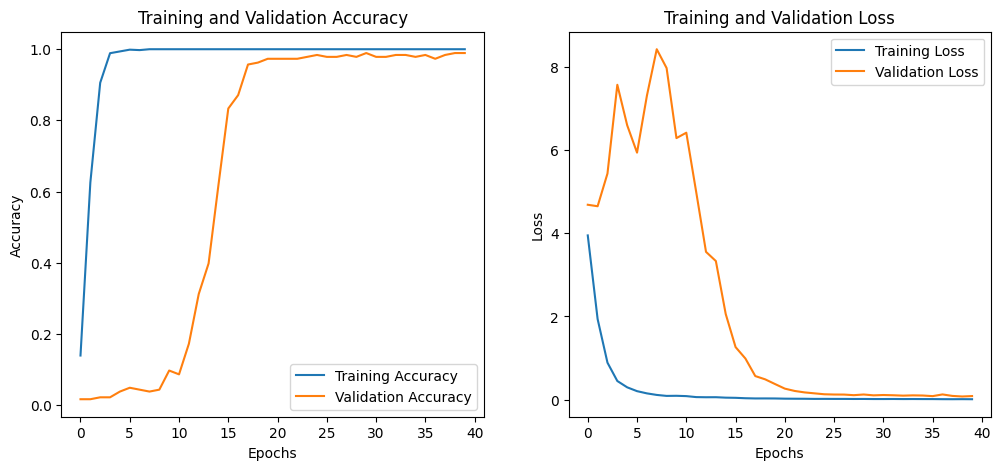

In [6]:
def _draw_accuracy_and_loss_curves2(epochs_range, acc, loss, val_acc=None, val_loss=None):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    return plt


def train_model(
    model,
    X_train, y_train, X_test, y_test,
    validation_data, callbacks,
    label_encoder,
    model_filepath,
    model_save_dir='ml_models/trained/',
    model_name='simple_cnn_lfw_anony_v1',
    batch_size=32,
    epochs=50,
    show_logs=False
    ):
    """
    Train facial recognition model.

    :param model: from create_model()
    :param X_train: from prepare_data_train_model()
    :param y_train: from prepare_data_train_model()
    :param X_test: from prepare_data_train_model()
    :param y_test: from prepare_data_train_model()
    :param validation_data: from prepare_data_train_model()
    :param callbacks: from create_model()
    :param label_encoder: from get_data_from_db()
    :param model_filepath: from create_model()
    :param model_save_dir: same as in create_model()
    :param model_name: same as in create_model()
    --- Training Settings ---
    :param batch_size: Batch size
    :param epochs: Maximum number of training epochs
    --- Display print logs ---
    :param show_logs:

    :return: dict
    """
    # --- ----------------- ---
    # --- 7. Model Training ---
    # --- ----------------- ---

    # Display model parameters
    if show_logs:
        print("Custom configuration loaded:")
        print(f"  - Model Name: {model_name}")
        print(f"  - Epochs: {epochs}, Batch Size: {batch_size}")

    if show_logs: print("\n--- Start training ---")
    try:
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=(show_logs==True)
        )
        if show_logs: print("--- Training completed ---")

    except Exception as e:
        encoder_save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_label_encoder.joblib")
        print("\nSaving the label encoder (even if training failed)...")
        data_loader.save_label_encoder(label_encoder, encoder_save_path)
        raise Exception(f"\nError during training: {e}")


    # --- ---------------- ---
    # --- 8. Post-Training ---
    # --- ---------------- ---
    encoder_save_path = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_label_encoder.joblib")
    if show_logs: print("\n--- Saving the label encoder ---")
    data_loader.save_label_encoder(label_encoder, encoder_save_path)

    # Evaluation
    eval_loss, eval_acc = model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    if history is not None:
        if show_logs: print("\n--- Displaying learning curves ---")
        try:
            acc = history.history['accuracy']
            loss = history.history['loss']
            val_acc = history.history['val_accuracy'] if validation_data else None
            val_loss = history.history['val_loss'] if validation_data else None
            epochs_range = range(len(acc))

            plt_obj = _draw_accuracy_and_loss_curves2(epochs_range, acc, loss, val_acc, val_loss)
            buf = io.BytesIO()
            plt_obj.savefig(buf, format='png')
            buf.seek(0)
            image_pil = Image.open(buf)

            plot_save_path = os.path.join(model_save_dir, f"{model_name}_training_curves.pdf")
            plt.savefig(plot_save_path, format='pdf', bbox_inches='tight')
            if show_logs: print(f"Curves saved in : {plot_save_path}")
        except Exception as plot_e:
            print(f"Error generating/saving curves: {plot_e}")

    if show_logs:
        print(f"The best model should be saved in : {model_filepath}")
        print(f"The label encoder is saved in : {encoder_save_path}")

    return {
        "curves": image_pil,
        "confusion_matrix": cm,
        "classification_report": report,
        "evaluation": {
            "loss": eval_loss,
            "accuracy": eval_acc
        }
    }



# Start timer
print("--- Starting the Training Script ---")
start_time = time.time()

# Train Model
res = train_model(
    model,
    X_train, y_train, X_test, y_test,
    validation_data, callbacks, label_encoder, model_filepath,
    model_save_dir=MODEL_SAVE_DIR,
    model_name=MODEL_NAME,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

)
for key, val in res.items(): print(f"\n{key} : {val}")

# End timer
end_time = time.time()
duration = end_time - start_time
print(f"--- Training Script Completed in {duration:.2f} secondes ---")

# Predict noised image

In [8]:
def preprocess_single_image(
    image_array: np.array,
    input_shape,
    ):
    """
    Resizes, normalizes and formats a single image for prediction.
    """
    try:
        width, height, channels = input_shape
        image = formate_ml_image(image_array, width, height, channels==3)
        image = np.expand_dims(image, axis=-1)
        image = np.expand_dims(image, axis=0)
        print(f"Preprocessed image, final shape: {image.shape}")
        return image
    except FileNotFoundError:
        print(f"Error: Image file not found: {image_path}")
        return None
    except Exception as e:
        print(f"Error during image preprocessing {image_path}: {e}")
        return None


def predict_image(
    image_array: np.ndarray,
    model_save_dir: str = 'ml_models/trained/',
    model_name: str = 'simple_cnn_lfw_anony_v1',
    input_shape: tuple = (100, 100, 1),
    show_logs = False,
    ):
    """
    Loads the model and encoder, predicts the identity for an image.

    :param image_array: Single image as a NumPy array
    :param model_save_dir: Directory containing the model and encoder
    :param model_name: Base name of the model
    :param input_shape: Tuple (H, W, C) representing the expected size

    :return: predicted label (str)
    """
    # --- ------------------------------- ---
    # --- 1. Load Configuration and Paths ---
    # --- ------------------------------- ---
    if show_logs: print("--- Starting the Prediction Script ---")

    model_filepath = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}.h5")
    encoder_filepath = os.path.join(MODEL_SAVE_DIR, f"{MODEL_NAME}_label_encoder.joblib")

    if show_logs:
        print(f"  - Model used: {model_filepath}")
        print(f"  - Encoder used: {encoder_filepath}")
        print(f"  - Image to predict: NumPy array, shape={image_array.shape}")

    # --- ------------------------- ---
    # --- 2. Load Model and Encoder ---
    # --- ------------------------- ---
    if show_logs: print("\n--- Loading the model and encoder ---")
    if not os.path.exists(model_filepath):
        raise Exception(f"Error: Template file not found: {model_filepath}")
    model = load_model(model_filepath)

    # Load the label encoder
    label_encoder = data_loader.load_label_encoder(encoder_filepath)
    if label_encoder is None:
        raise Exception("Critical error: Unable to load label encoder.")

    # --- ----------------------------- ---
    # --- 3. Preprocess the Input Image ---
    # --- ----------------------------- ---
    if show_logs: print("\n--- Preprocessing of the input image ---")
    preprocessed_image = preprocess_single_image(image_array, input_shape)
    if preprocessed_image is None:
        raise Exception("Image preprocessing failed.")

    # --- ---------------------- ---
    # --- 4. Make the Prediction ---
    # --- ---------------------- ---
    if show_logs: print("\n--- Prediction ---")
    try:
        prediction_probabilities = model.predict(preprocessed_image)

        predicted_index = np.argmax(prediction_probabilities[0])
        prediction_confidence = prediction_probabilities[0][predicted_index]

        predicted_label = label_encoder.inverse_transform([predicted_index])[0]
        if show_logs:
            print("\n--- Prediction Result ---")
            print(f"  - Predicted Identity (Subject ID) : {predicted_label}")
            print(f"  - Trust : {prediction_confidence:.4f} ({prediction_confidence*100:.2f}%)")
        return predicted_label, prediction_confidence
    except Exception as e:
        print(f"Error in prediction: {e}")



user = 43
image_path = f"../data/dataset-lfw_reconstructed/reconstructed_{user}_2.png"
image = np.array(Image.open(image_path))

result = predict_image(image, INPUT_SHAPE)
predicted_label, prediction_confidence = result
print(f"  - Predicted Identity (Subject ID) : {predicted_label}")
print(f"  - Trust : {prediction_confidence:.4f} ({prediction_confidence*100:.2f}%)")

LabelEncoder chargé depuis : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
Preprocessed image, final shape: (1, 100, 100, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
  - Predicted Identity (Subject ID) : 43
  - Trust : 0.9986 (99.86%)


D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 100, 100, 1, 1))
  warnings.warn(msg)
